In [4]:
#Loaded Libraries

library(tidyverse)
library(repr)
library(tidymodels)
library(caret)
install.packages("expss")
library(expss)
library(ggplot2)
library(GGally)
library("gridExtra")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [5]:
# Data Loaded 

cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                           col_names = c("age", 
                                         "sex", 
                                         "cp", 
                                         "trestbps", 
                                         "chol", 
                                         "fbs", 
                                         "restercg", 
                                         "thalach", 
                                         "exang", 
                                         "oldpeak", 
                                         "slope", 
                                         "ca", 
                                         "thal", 
                                         "num"))
cleveland_data$num <- as.factor(cleveland_data$num)
head(cleveland_data)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restercg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [6]:
# see if there is other number rather than 0-4 in the num column
cleveland_data  %>%
    select(num)  %>% 
    unlist() %>% 
    levels()

# transform num from 0-4 to 0 or 1 (1, 2, 3, 4) and store into diagnosis variable
cleveland_data <- cleveland_data %>%
                  mutate(diagnosis = dplyr::recode(num, '0' = 'absent', .default = 'present'))

head(cleveland_data)

# to see how the original data distribute
cleveland_data %>% 
    group_by(diagnosis) %>%
    summarize(n = n())

# We select all the numerical columns and diagnosis column
cleveland_data2 <- cleveland_data%>%
            select(age, trestbps, chol, thalach, oldpeak, diagnosis)
head(cleveland_data2)

heart_tidy <- cleveland_data2

# Above codes are from the proposal, with the tidy dataset cleveland_data2 renamed as heart_tidy

[1] "0" "1" "2" "3" "4"

age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,absent
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,present
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,present
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,absent
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,absent
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,absent


`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<fct>,<int>
absent,164
present,139


age,trestbps,chol,thalach,oldpeak,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,absent
67,160,286,108,1.5,present
67,120,229,129,2.6,present
37,130,250,187,3.5,absent
41,130,204,172,1.4,absent
56,120,236,178,0.8,absent


[1] 23

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8000000
kap,binary,0.5913549


          Truth
Prediction absent present
   absent      36      10
   present      5      24

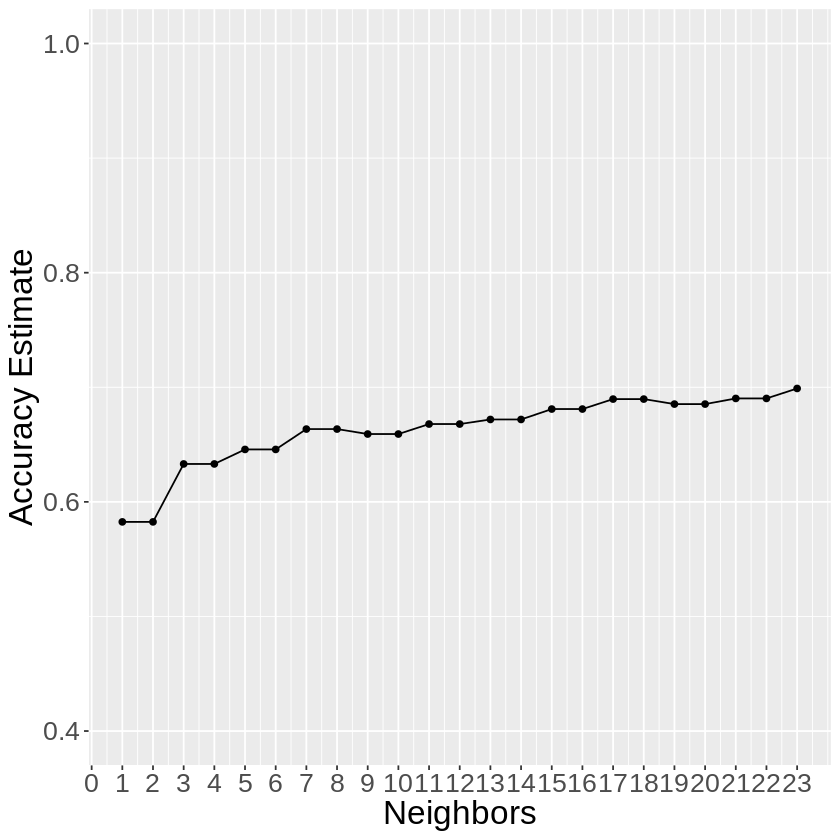

In [7]:
# We will use KNN Classification with 10 folds cross-validation for choosing the appropriate k value. The resulting accuracy will be calculated

# Splitting the data to training and testing data

heart_split <- initial_split(heart_tidy, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

# Perform 10 folds Cross-Validation for heart_train dataset to choose appropriate k
set.seed(2022)

heart_10fold <- vfold_cv(heart_train, v=10, strata = diagnosis)

set.seed(2022)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")
#graph of different accuracy
knn_recipe <- recipe(diagnosis ~ chol + thalach + oldpeak, data = heart_train) %>% # Important !!!!!!!!!!!! Using only 3 predictors (chol,thalach, oldpeak) will gain the max accuracy
            step_center(all_predictors()) %>%
            step_scale(all_predictors())

heart_workflow <- workflow() %>%
                add_model(knn_spec) %>%
                add_recipe(knn_recipe)

# gridvals <- tibble(neighbors = seq(from = 1, to = 40))

# heart_result <- heart_workflow %>%
#                 tune_grid(resamples = heart_10fold, grid = gridvals) %>%
#                 collect_metrics() 

# accuracy <-  heart_result %>%
#             filter(.metric == "accuracy") 

# Duffy
# accuracy_versus_k <- ggplot(accuracy, aes(x = neighbors, y = mean))+
#        geom_point() +
#        geom_line() +
#        labs(x = "Neighbors", y = "Accuracy Estimate") +
#        scale_x_continuous(breaks = seq(0, 23, by = 1)) +  # adjusting the x-axis
#        scale_y_continuous(limits = c(0.4, 1.0)) +# adjusting the y-axis 
#        theme(text=element_text(size=20))

# accuracy_versus_k

# appropriate_k <- accuracy %>%
#                 arrange(-mean) %>%
#                 slice(1) %>%
#                 select(neighbors) %>%
#                 pull()
# appropriate_k


# set.seed(2022)
# knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbor = appropriate_k) %>%
#             set_engine("kknn") %>%
#             set_mode("classification")

# heart_fit <- workflow() %>%
#                     add_model(knn_spec_new) %>%
#                     add_recipe(knn_recipe) %>%
#                     fit(data = heart_train)

# heart_predictions <- predict(heart_fit, heart_test) %>%
#                     bind_cols(heart_test)

# heart_metrics <- heart_predictions %>% 
#     metrics(truth = diagnosis, estimate = .pred_class)

# heart_conf_mat <- heart_predictions %>%
#     conf_mat(truth =diagnosis, estimate = .pred_class)

# heart_metrics
# heart_conf_mat

In [16]:
# warning - long run time with 1-40
gridvals <- tibble(neighbors = seq(from = 1, to = 40, step = 2))

heart_result <- heart_workflow %>%
                tune_grid(resamples = heart_10fold, grid = gridvals) %>%
                collect_metrics() 

accuracy <-  heart_result %>%
            filter(.metric == "accuracy") 

## 2.5 Tuning the Classifier

We then plot the accuracy values against k values to find the most optimal value for the parameter k.  

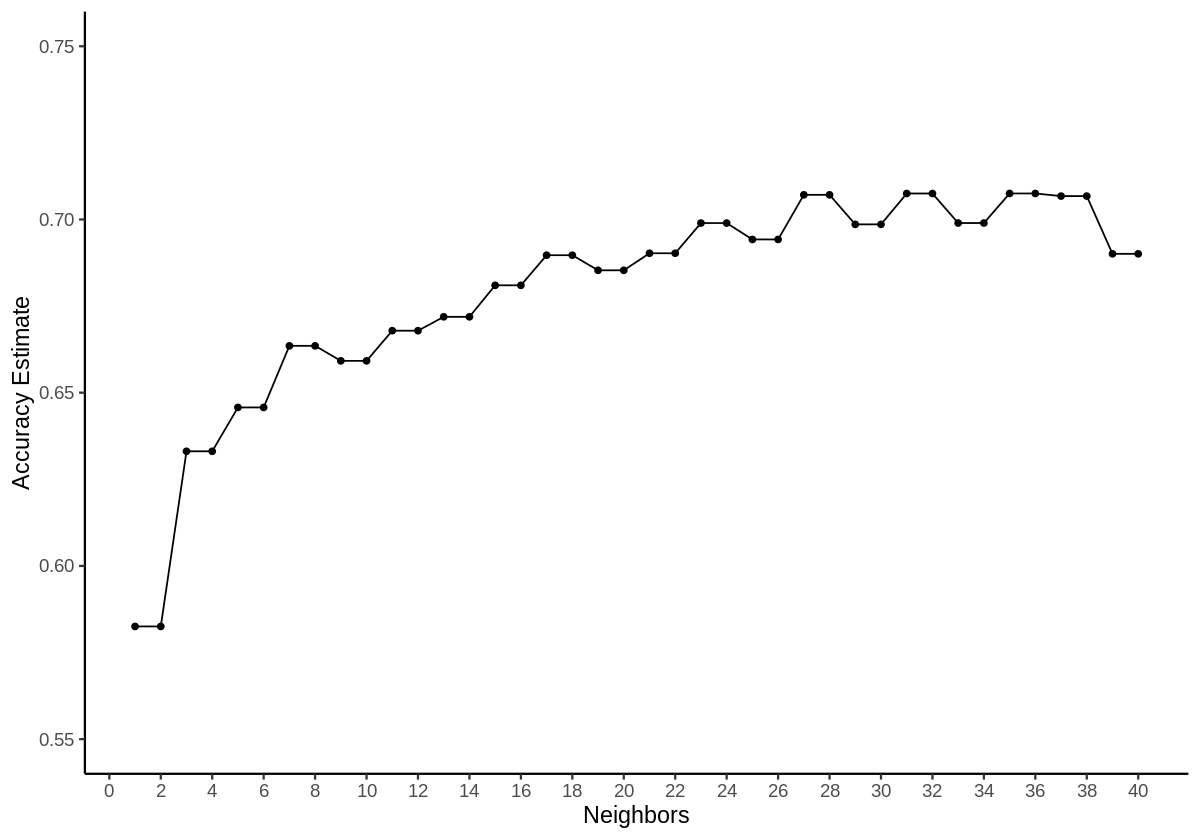

In [18]:
options(repr.plot.width=10, repr.plot.height=7)
# accuracy
accuracy_versus_k <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 40, by = 2)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.55, 0.75)) +# adjusting the y-axis 
       theme(text=element_text(size=20)) +
       theme_classic(base_size = 14)

accuracy_versus_k



We extract the number of neighbors associated with the highest accuracy estimate and save that value as appropriate_k. We can also visually see that the accuracy of the model peaks around K = 35 which provides a high accuracy model and changing the K value to a nearby one doesn’t decrease accuracy too much, so that our choice is reliable in the presence of uncertainty. 

In [19]:
appropriate_k <- accuracy %>%
                arrange(-mean) %>%
                slice(1) %>%
                select(neighbors) %>%
                pull()
appropriate_k

[1] 35

### 2.6 Training the Classifier
Next, we create our final model specification using appropriate_k as the number of nearest neighbors and fit the model to our training set to create our finalized classifier.

In [20]:
set.seed(2022)
# final model specification
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbor = appropriate_k) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# workflow
heart_fit <- workflow() %>%
                    add_model(knn_spec_new) %>%
                    add_recipe(knn_recipe) %>%
                    fit(data = heart_train)


### 2.7 Predicting the Testing Set
We use our finalized trained KNN classfication model to predict heart disease in patients in our testing set. We then bind the predictions produced by our model with the original testing set, so that we can compare our predictions to the true class values.

In [22]:
heart_predictions <- predict(heart_fit, heart_test) %>%
                    bind_cols(heart_test)
head(heart_predictions)


.pred_class,age,trestbps,chol,thalach,oldpeak,diagnosis
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
present,67,160,286,108,1.5,present
absent,52,172,199,162,0.5,absent
absent,54,140,239,160,1.2,absent
present,60,130,206,132,2.4,present
present,50,120,219,158,1.6,absent
absent,64,140,335,158,0.0,present


## 3. Results
Comparing the predictions of our KNN classfication model on the testing data to the actual value, we can evaluate our model's performance by calculating the overall accuracy of our model's predictions. We achieve a final accuracy rate of 78.67 %.

In [23]:
heart_summary <- heart_predictions %>%
                  metrics(truth = diagnosis, estimate = .pred_class) %>%
                  filter(.metric == "accuracy")

heart_accuracy <- heart_summary %>%
                select(.estimate) %>%
                pull()

paste(round(heart_accuracy*100,2), "%")


[1] "78.67 %"

We also put the prediction results into a confusion matrix comparing with the actual results, this allow us to see how many false positives and false negatives our models gave.

In [24]:
heart_conf_mat <- heart_predictions %>%
    conf_mat(truth =diagnosis, estimate = .pred_class)

heart_conf_mat

          Truth
Prediction absent present
   absent      35      10
   present      6      24

Our model gave 6 false positives and 10 false negatives. This might not be a very good model to use in a medical field as false negatives may lead to a misdiagnosis of heart disease and patient will not be treated in time for their condition. However, our model produced a relatively low number of false positives. This could be good in a medical perspective in that not a lot of patients will have to go through additional invasive testing for a final accurate diagnosis. 